# **Overview**

# **Library and Configuration**

In [1]:
import sys
sys.path.append("..")

import importlib

from warnings import filterwarnings
filterwarnings('ignore')

# Core Library
from collections import Counter
import pandas as pd
import numpy as np
import math
from pathlib import Path

# Visualization tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Path tools
import os
import glob

# Computer vision tools
import cv2
import re

# Configuration
from src.config import config

# Source code helper
import src.dots_extractor_v2.utils as utils
import src.dots_extractor_v2.plot_metadata as metadata
import src.dots_extractor_v2.dot_detection as detector
import src.dots_extractor_v2.missing_solver as solver
import src.dots_extractor_v2.mapper as mapper

def r(modules=[utils, metadata, detector, solver, mapper]):
    for module in modules:
        importlib.reload(module)

r()

location = "Macritchie Reservoir"
year = 2014

np.printoptions(legacy="1.25")
sns.set_style("white")

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

print('Library Ready!')

Library Ready!


# **Demo Initialization**

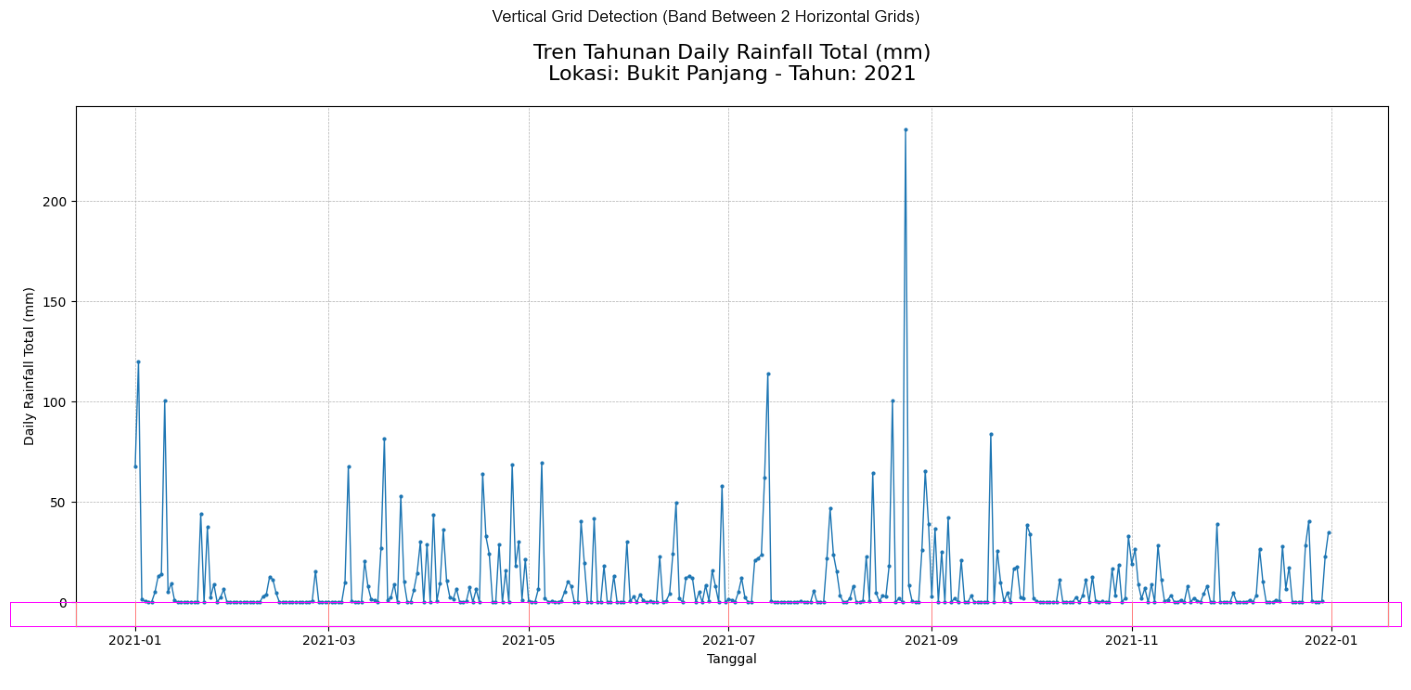

[71, 135, 343, 559, 774, 993, 1209, 1424, 1485]

In [317]:
def generate_demo(location, year):
    location = location.replace(" ", "_")

    demo_path = config.paths.raw/f"Train/{location}/Plot_Daily_Rainfall_Total_mm_{year}.png"
    demo_csv = config.paths.raw/f"Train/{location}/Data_Gabungan_Lainnya_{year}.csv"

    return demo_path, demo_csv

png, csv = generate_demo(location, year)

demo_image = cv2.imread(png)
demo_blue = utils.extract_blue_mask(demo_image)

demo_df = pd.read_csv(csv)
demo_df["Date"] = pd.to_datetime(demo_df["Date"])

demo_df = (
    demo_df
    .set_index("Date")
    .reindex(
        pd.date_range(
            start=demo_df["Date"].min(),
            end=demo_df["Date"].max(),
            freq="D"
        )
    )
    .rename_axis("Date")
    .reset_index()
)
r()
n_days = len(demo_df)
vertical_grid, horizontal_grid = metadata.detect_grid(demo_image, right_px=100)
vertical_grid

# **Visualization Helper**

For sanity check after extraction, we build a helper to overlay plot with red dots to assure that our extractor is actually works.

In [12]:
def overlay_red_points(
    image_bgr,
    points,
    title="Points Detected",
):
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(50, 20))
    plt.imshow(img_rgb)

    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    plt.scatter(xs, ys, c="red", s=10, zorder=1)

    plt.title(title, fontsize=40)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def overlay_red_mask(
    image_bgr,
    mask,
    title="Overlay detected mask pixels",
):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    ys, xs = np.where(mask > 0)

    plt.figure(figsize=(50, 18))
    plt.imshow(img_rgb)

    plt.scatter(xs, ys, c="red", s=10, zorder=2)

    plt.title(title, fontsize=40)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def visualize_gaps_on_image(
    image_bgr,
    gaps,
    alpha=0.35,
):
    img = image_bgr.copy()
    h, w, _ = img.shape

    overlay = img.copy()

    for start, end in gaps:
        xs = start
        xe = end

        xs = max(0, min(xs, w - 1))
        xe = max(0, min(xe, w - 1))

        cv2.rectangle(
            overlay,
            (xs, 0),
            (xe, h),
            color=(0, 0, 255),
            thickness=-1
        )

    vis = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

    plt.figure(figsize=(14, 6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Detected Gaps Overlay (Red = No Blue Presence)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def draw_roi_overlay(
    image_bgr: np.ndarray,
    x0: int = 0,
    x1: int = 1500,
    y0: int = 0,
    y1: int = 700,
    color=(0, 0, 255),
    thickness=2,
):
    img = image_bgr.copy()
    h, w = img.shape[:2]

    x0 = max(0, min(w - 1, int(x0)))
    x1 = max(0, min(w - 1, int(x1)))
    y0 = max(0, min(h - 1, int(y0)))
    y1 = max(0, min(h - 1, int(y1)))

    if x1 <= x0 or y1 <= y0:
        raise ValueError("Invalid ROI coordinates")

    cv2.rectangle(
        img,
        (x0, y0),
        (x1, y1),
        color,
        thickness,
    )

    plt.figure(figsize=(15, 7))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("ROI Overlay")
    plt.tight_layout()
    plt.show()

def recreate_plot(rainfall, location, year):
    plt.figure(figsize=(15, 7))
    plt.grid(True, alpha=0.7, linestyle="--")

    plt.plot(rainfall, marker="o", markersize=1.5, color = "#1F77B4", linewidth=1)
    plt.title(f"Extracted Daily Rainfall \nLocation: {location} - Year: {year}", fontsize=15)

    plt.xlabel("Date")
    plt.ylabel("Daily Rainfall Total (mm)")

    plt.tight_layout()
    plt.plot()

# **Detecting Dots**

Length of extracted dots : 365


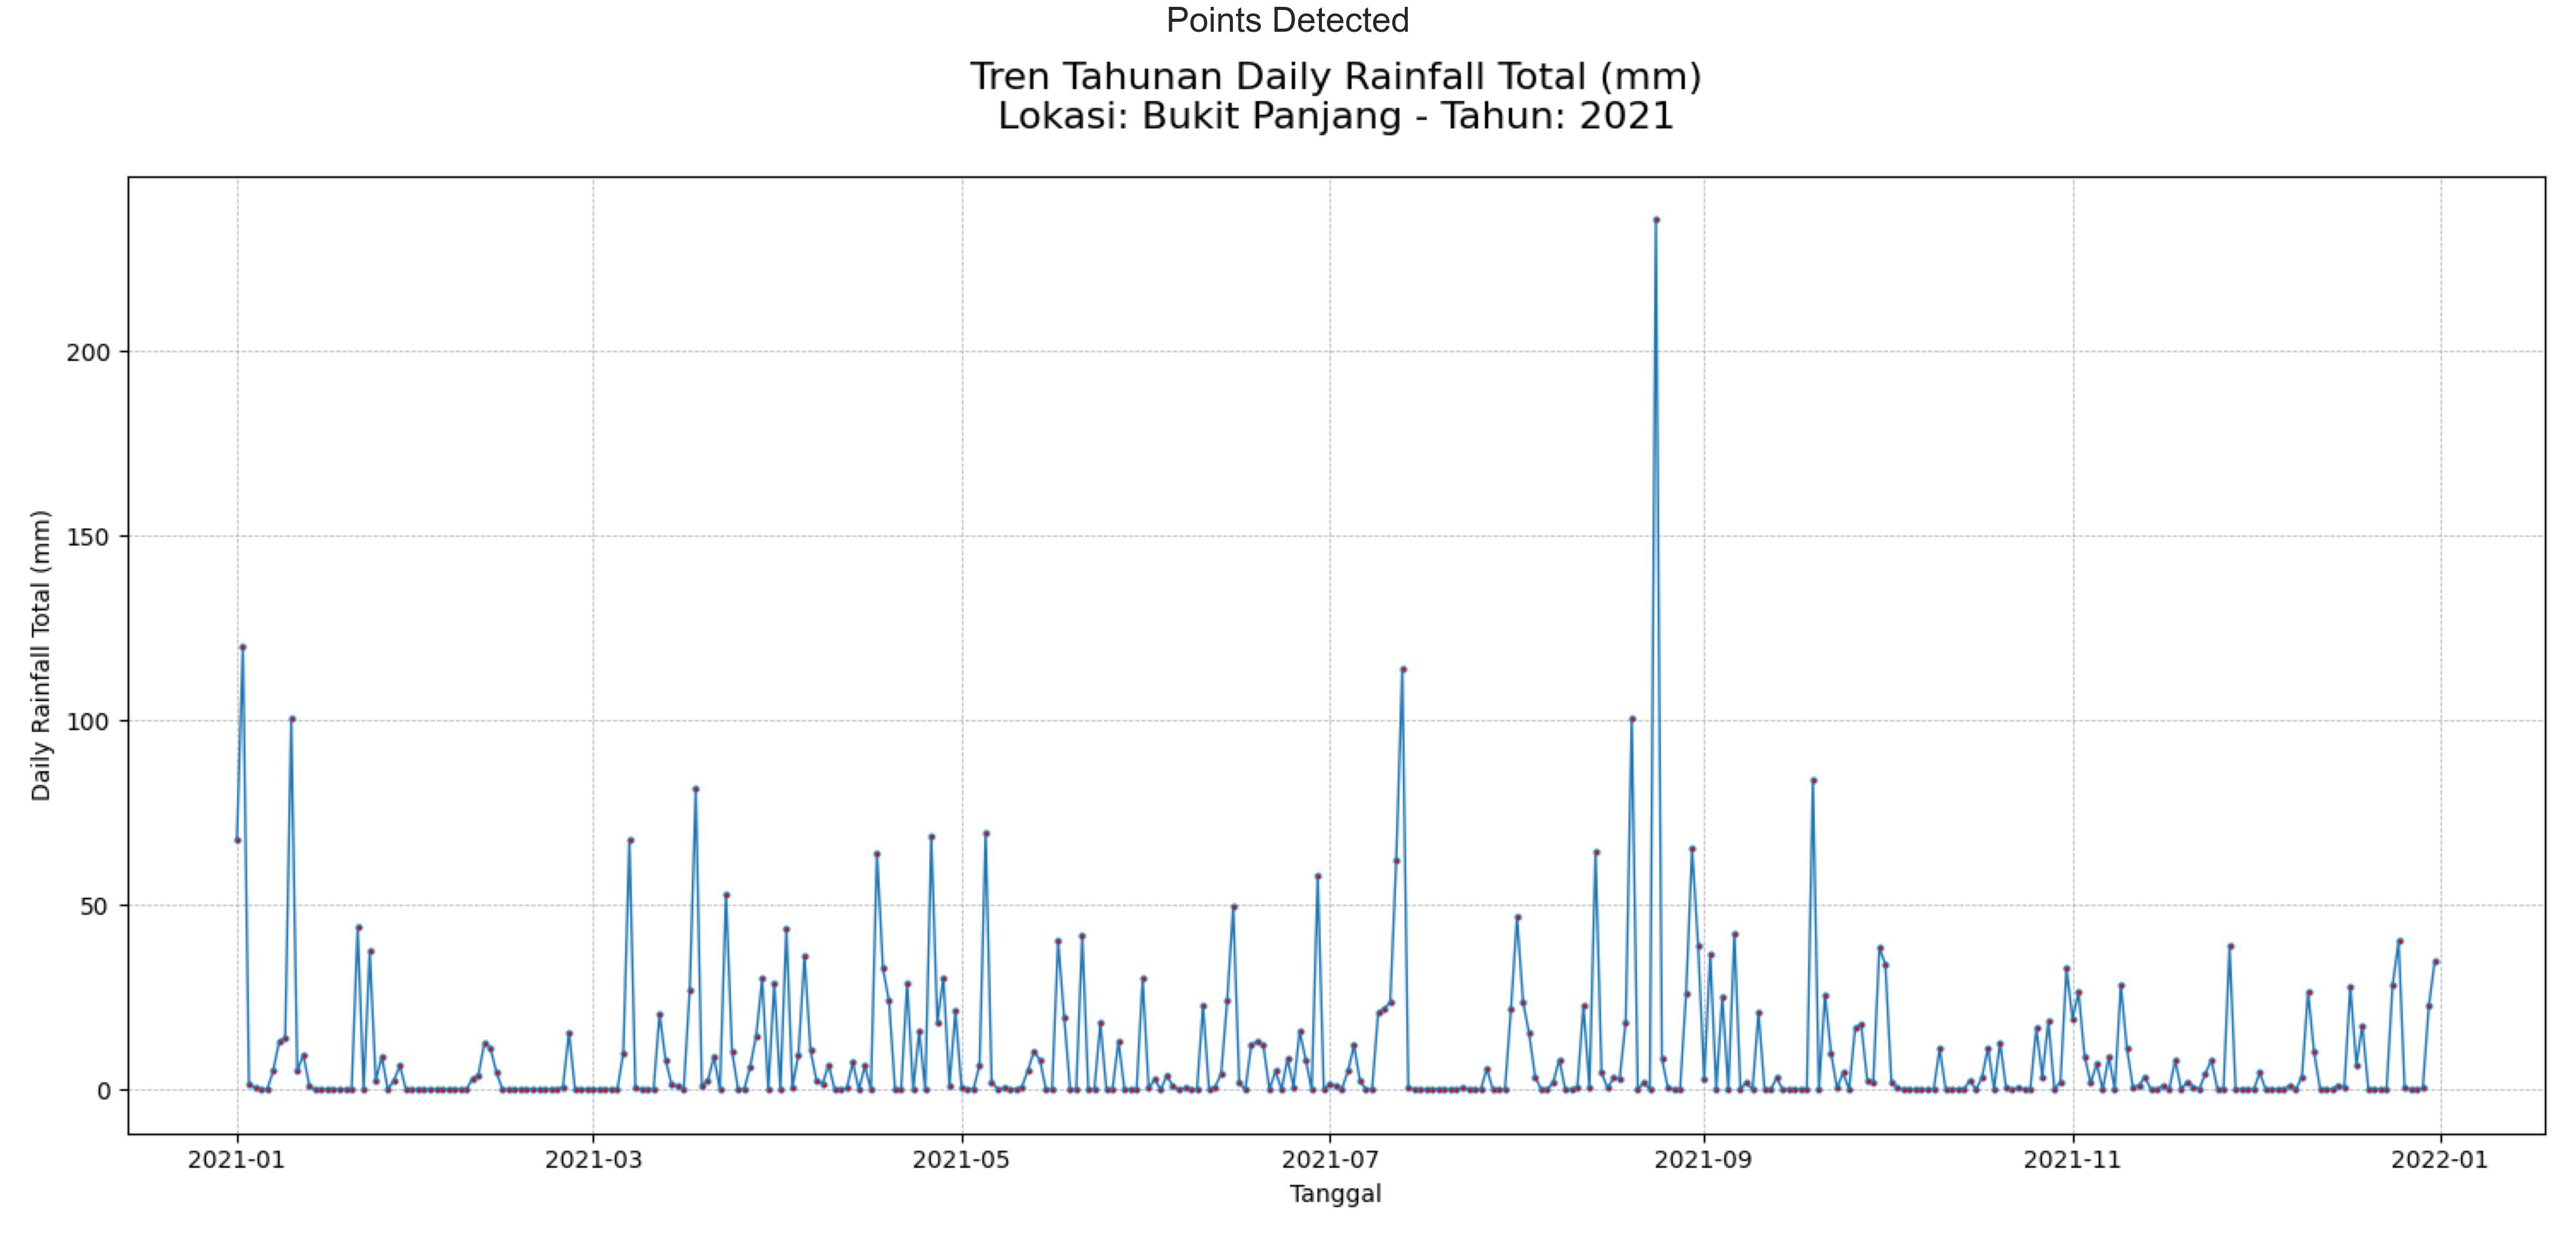

In [318]:
mask, (x0, x1) = detector.detect_dot_mask(
    image_bgr=demo_image,
    target_rgb=(31, 119, 180),
    tolerance=4,
)

dots = detector.extract_dots(mask)
print(f"Length of extracted dots : {len(dots)}")

overlay_red_mask(image_bgr=demo_image, mask=mask)
overlay_red_points(image_bgr=demo_image, points=dots)

# **OCR Extraction**

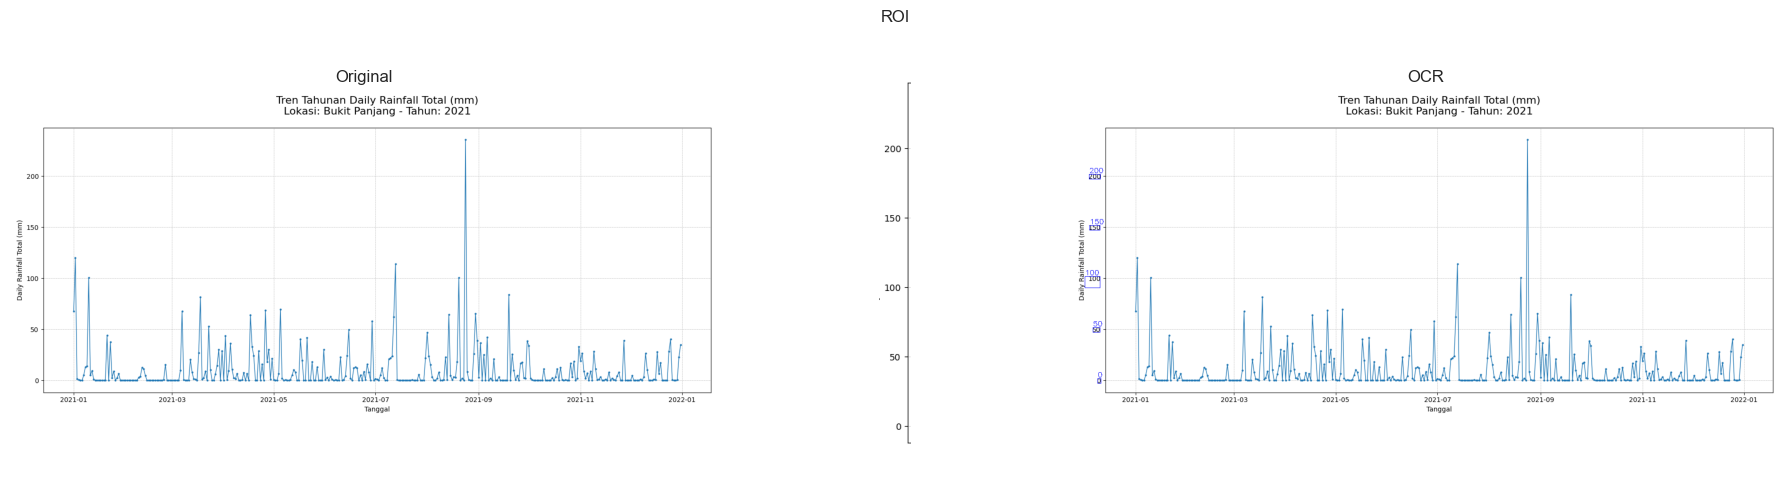

Labels OCR Result:


[('200', 36, 180, 24, 10),
 ('150', 37, 288, 22, 10),
 ('100', 27, 396, 32, 24),
 ('50', 44, 504, 15, 10),
 ('0', 54, 612, 7, 10)]

In [319]:
label_ocr = metadata.perform_ocr(demo_image,
                                 punctuation=False,
                                 roi_x0=27,
                                 roi_x1=vertical_grid[0]+5,
                                 show=True)
print("Labels OCR Result:")
label_ocr

In [332]:
labels = metadata.extract_yticks_from_ocr(label_ocr)
items = labels.items()

snapped_items = utils.snap_values(
    items,
    horizontal_grid,
    get_value=lambda item: item[1][1],
    set_value=lambda item, y: (item[0], (item[1][0], y)),
    tol_px=1,
)

snapped_labels = dict(snapped_items)
snapped_labels

{0.0: (57.5, 616),
 50.0: (51.5, 508),
 100.0: (43.0, 408.0),
 150.0: (48.0, 292),
 200.0: (48.0, 184),
 247.6851851851852: (48.0, 82)}

In [341]:
labels

{0.0: (57.5, 617.0),
 50.0: (51.5, 509.0),
 100.0: (43.0, 408.0),
 150.0: (48.0, 293.0),
 200.0: (48.0, 185.0),
 247.6851851851852: (48.0, 82.0)}

In [340]:
50 + 150 * (508-82)/(508-184)

247.22222222222223

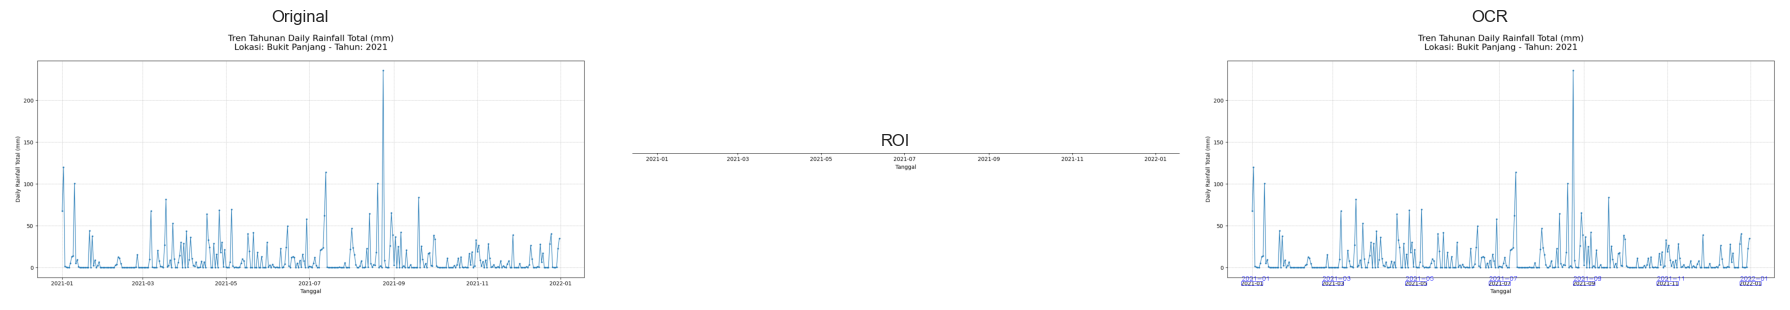

OCR Result:


[('2021-01', 107, 652, 55, 10),
 ('2021-03', 316, 652, 55, 10),
 ('2021-05', 531, 652, 55, 10),
 ('2021-07', 747, 652, 55, 10),
 ('2021-09', 965, 652, 56, 10),
 ('2021-11', 1181, 652, 56, 10),
 ('2022-01', 1396, 652, 55, 10)]

In [322]:
date_ocr = metadata.perform_ocr(demo_image,
                                     punctuation=True,
                                     roi_y0=horizontal_grid[-1],
                                     show=True)
print("OCR Result:")
date_ocr

In [323]:
xticks = metadata.extract_xticks_from_ocr(date_ocr)
snapped_xticks = utils.snap_values(
    xticks,
    vertical_grid,
    get_value=lambda item: item[0],
    set_value=lambda item, x: (x, item[1], item[2]),
    tol_px=3,
)

snapped_xticks

[(135, Timestamp('2021-01-01 00:00:00'), '2021-01'),
 (343, Timestamp('2021-03-01 00:00:00'), '2021-03'),
 (559, Timestamp('2021-05-01 00:00:00'), '2021-05'),
 (774, Timestamp('2021-07-01 00:00:00'), '2021-07'),
 (993, Timestamp('2021-09-01 00:00:00'), '2021-09'),
 (1209, Timestamp('2021-11-01 00:00:00'), '2021-11'),
 (1424, Timestamp('2022-01-01 00:00:00'), '2022-01')]

In [324]:
def most_common_x_distances(
    dots,
    top_k: int = 3,
    verbose: bool = False,
):
    xs = sorted(x for x, _ in dots)

    dxs = []
    for i in range(len(xs) - 1):
        dx = xs[i + 1] - xs[i]
        if dx > 0:
            dxs.append(dx)

    if not dxs:
        raise ValueError("No valid dx found")

    counter = Counter(dxs)
    base_dx, base_freq = counter.most_common(1)[0]
    candidates = [(base_dx, base_freq)]

    for d in (base_dx - 1, base_dx + 1):
        if d > 0 and d in counter:
            candidates.append((d, counter[d]))

    candidates.sort(key=lambda x: -x[1])
    if verbose:
        print("[DEBUG] dx histogram:", counter.most_common())
        print("[DEBUG] selected candidates:", candidates)

    return candidates[:top_k]

In [325]:
top_dx = metadata.most_common_x_distances(
    dots,
    verbose=True
)
candidates = sorted([delta for delta, _ in top_dx])
candidates

[DEBUG] dx histogram: [(4, 194), (3, 170)]
[DEBUG] selected candidates: [(4, 194), (3, 170)]


[3, 4]

In [326]:
def is_year_end(ts):
    return ts.month == 12 and ts.day == 31

def is_year_start(ts):
    return ts.month == 1 and ts.day == 1

def find_data_boundaries(
    blue_mask: np.ndarray,
    vertical_grid: list[int],
    xticks: list[tuple],
    delta: int,
) -> dict:
    if len(vertical_grid) < 4:
        raise ValueError("vertical_grid must contain at least 4 entries (border, timestamps, border)")

    contours, _ = cv2.findContours(
        blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:
        raise ValueError("No blue plot detected")

    x_coords = np.concatenate([cnt[:, 0, 0] for cnt in contours])
    blue_min_x = int(x_coords.min())
    blue_max_x = int(x_coords.max())

    border_left = int(vertical_grid[0])
    first_ts = int(vertical_grid[1])
    last_ts = int(vertical_grid[-2])
    border_right = int(vertical_grid[-1])


    if blue_min_x >= first_ts - delta:
        data_start = first_ts
    else:
        data_start = border_left

    first_xtick_x, _, _ = xticks[0]
    last_xtick_x, last_xtick_ts, _ = xticks[-1]

    if is_year_end(last_xtick_ts):
        data_end = last_ts

    elif is_year_start(last_xtick_ts):
        if blue_max_x <= last_ts + delta:
            data_end = last_ts
        else:
            data_end = border_right
    else:
        if blue_max_x <= last_ts:
            data_end = last_ts
        else:
            data_end = border_right

    if border_left == data_start:
        data_start += 2

    return {
        "data_start": int(data_start),
        "data_end": int(data_end)
    }

boundaries = find_data_boundaries(
    blue_mask=demo_blue,
    vertical_grid=vertical_grid,
    xticks=snapped_xticks,
    delta=max(candidates)
)
x0 = boundaries["data_start"]
x1 = boundaries["data_end"]

boundaries

{'data_start': 135, 'data_end': 1424}

In [327]:
def extend_xticks(
    xticks,
    data_boundaries,
):

    assert len(xticks) >= 2, "Need at least 2 xticks to infer spacing"

    data_start = data_boundaries["data_start"]
    data_end = data_boundaries["data_end"]

    xticks = sorted(xticks, key=lambda x: x[0])

    xs = [x for x, _, _ in xticks]
    ts = [t for _, t, _ in xticks]

    dxs = [xs[i] - xs[i - 1] for i in range(1, len(xs))]
    dts = [ts[i] - ts[i - 1] for i in range(1, len(ts))]

    dx = float(np.median(dxs))
    dt = pd.to_timedelta(
        np.median([dt.value for dt in dts]),
        unit="ns",
    )

    new_ticks = []

    x0, ts0, _ = xticks[0]
    cur_x = x0
    cur_ts = ts0

    while cur_x - dx >= data_start:
        cur_x -= dx
        cur_ts -= dt
        new_ticks.append(
            (cur_x, cur_ts, cur_ts.strftime("%Y-%m"))
        )

    new_ticks = new_ticks[::-1]

    xN, tsN, _ = xticks[-1]
    cur_x = xN
    cur_ts = tsN

    right_ticks = []

    while cur_x + dx <= data_end:
        cur_x += dx
        cur_ts += dt
        right_ticks.append(
            (cur_x, cur_ts, cur_ts.strftime("%Y-%m"))
        )

    return new_ticks + xticks + right_ticks

xticks_full = extend_xticks(snapped_xticks, boundaries)
xticks_full

[(135, Timestamp('2021-01-01 00:00:00'), '2021-01'),
 (343, Timestamp('2021-03-01 00:00:00'), '2021-03'),
 (559, Timestamp('2021-05-01 00:00:00'), '2021-05'),
 (774, Timestamp('2021-07-01 00:00:00'), '2021-07'),
 (993, Timestamp('2021-09-01 00:00:00'), '2021-09'),
 (1209, Timestamp('2021-11-01 00:00:00'), '2021-11'),
 (1424, Timestamp('2022-01-01 00:00:00'), '2022-01')]

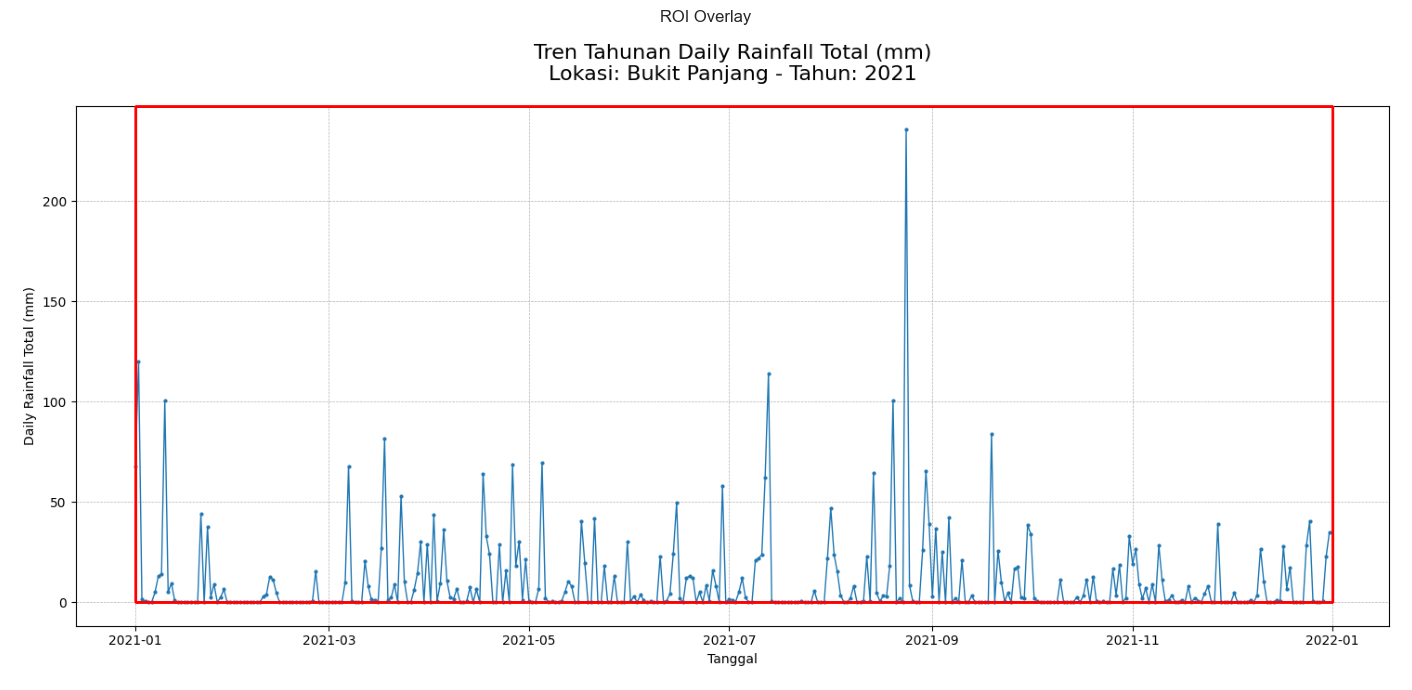

In [328]:
xticks_xs = [x for (x, _, _) in xticks_full]
labels_ys = [y for (_, (_, y)) in snapped_labels.items()]

x0 = min(xticks_xs)
x1 = max(xticks_xs)
y0 = min(labels_ys)
y1 = max(labels_ys)

overlay = draw_roi_overlay(
    demo_image,
    x0=x0,
    x1=x1,
    y0=y0,
    y1=y1
)

## **Dot and Gap Extraction**

Dot mask is extracted with `cv2.HITMISS` checking all over the cropped plot area outputting signal if it hit 3 x 3 kernel with spesific color. Assuming the core color is `RGB(31, 119, 180)` with additional tolerance of 5 is enough to ensure all dots is detected.

Some plots with a lot of number of days branching into two case: single detected 3 x 3 and horizontally merged dots with shape 3 x 6. The second case can lead us to repeatedly scanned dots, so we need a helper to separate them.

Target is plotted without dropping the missing value, thus we detect absence of color (in this case all blue-ish color). Since it's line plot, absence of line plot can give us information of missing value no matter how small the gaps. 

In [329]:
def round_day_with_cutoff(ts, cutoff_hour=16, cutoff_minute=1):
    ts = pd.Timestamp(ts)
    shift = pd.Timedelta(hours=24 - cutoff_hour, minutes=-cutoff_minute)
    return (ts + shift).floor("D")


def estimate_plot_time_window_from_xticks(
    xticks,
    data_start_px,
    data_end_px,
    cutoff_hour=16,
    cutoff_minute=00,
):
    assert len(xticks) >= 2

    xticks = sorted(xticks, key=lambda t: t[0])

    xs = np.array([x for x, _, _ in xticks], float)
    ts_ns = np.array([ts.value for _, ts, _ in xticks], np.int64)

    a, b = np.polyfit(xs, ts_ns, 1)

    t0_raw = pd.Timestamp(int(a * data_start_px + b))
    t1_raw = pd.Timestamp(int(a * data_end_px   + b))

    shift = pd.Timedelta(hours=24 - cutoff_hour, minutes=-cutoff_minute)

    t0 = (t0_raw + shift).floor("D")
    t1 = (t1_raw + shift).floor("D")

    print(t0_raw, t1_raw)
    print(t0, t1)
    if is_year_start(t1):
        t1 = t1 - pd.Timedelta(days=1)

    return min(t0, t1), max(t0, t1)


def expected_n_in_plot(csv_dates, t0, t1):
    csv_dates = pd.to_datetime(csv_dates).sort_values()

    t0 = pd.Timestamp(t0).normalize()
    t1 = pd.Timestamp(t1).normalize()

    window = t1 - t0
    n_expected = window.days + 1
    return n_expected


t0, t1 = estimate_plot_time_window_from_xticks(
    xticks=xticks_full,
    data_start_px=boundaries["data_start"],
    data_end_px=boundaries["data_end"],
)

expected_plot_n = expected_n_in_plot(demo_df["Date"], t0, t1)
extracted_dot_n = len(dots)
n_missing = expected_plot_n - extracted_dot_n

print("Expected dots found in plot :", expected_plot_n)
print("Extracted dots in plot      :", extracted_dot_n)
print("n missing based on plot     :", n_missing)

2021-01-01 00:56:13.283939072 2021-12-31 23:12:15.986302208
2021-01-01 00:00:00 2022-01-01 00:00:00
Expected dots found in plot : 365
Extracted dots in plot      : 365
n missing based on plot     : 0


In [330]:
def find_dots_near_xticks(
    xticks,
    dots,
    candidates,
    max_dx=1.0,
):
    results = []

    dots = list(dots)

    def find_best_dot(x_target):
        best = None
        best_dx = None
        for x, y in dots:
            dx = abs(x - x_target)
            if dx <= max_dx:
                if best_dx is None or dx < best_dx:
                    best_dx = dx
                    best = (x, y)
        return best

    for x_tick, date, label in xticks:
        dot = find_best_dot(x_tick)
        used_date = date

        if dot is None:
            for dx_step in candidates:
                d = find_best_dot(x_tick - dx_step)
                if d is not None:
                    dot = d
                    used_date = date - pd.Timedelta(days=1)
                    break

                # coba kanan
                d = find_best_dot(x_tick + dx_step)
                if d is not None:
                    dot = d
                    used_date = date + pd.Timedelta(days=1)
                    break

        results.append({
            "x_tick": x_tick,
            "date": used_date,
            "label": label,
            "dot": dot,
        })

    return results

matches = find_dots_near_xticks(xticks_full, dots, candidates)
matches

[{'x_tick': 135,
  'date': Timestamp('2021-01-01 00:00:00'),
  'label': '2021-01',
  'dot': (135, 470)},
 {'x_tick': 343,
  'date': Timestamp('2021-03-01 00:00:00'),
  'label': '2021-03',
  'dot': (343, 616)},
 {'x_tick': 559,
  'date': Timestamp('2021-05-01 00:00:00'),
  'label': '2021-05',
  'dot': (559, 615)},
 {'x_tick': 774,
  'date': Timestamp('2021-07-01 00:00:00'),
  'label': '2021-07',
  'dot': (774, 613)},
 {'x_tick': 993,
  'date': Timestamp('2021-09-01 00:00:00'),
  'label': '2021-09',
  'dot': (993, 610)},
 {'x_tick': 1209,
  'date': Timestamp('2021-11-01 00:00:00'),
  'label': '2021-11',
  'dot': (1209, 575)},
 {'x_tick': 1424,
  'date': Timestamp('2021-12-31 00:00:00'),
  'label': '2022-01',
  'dot': (1421, 541)}]

In [331]:
def pick_best_anchor_from_matches(matches):
    best = None

    for m in matches:
        dot = m["dot"]
        if dot is None:
            continue

        x_dot, _ = dot
        x_tick = m["x_tick"]
        dx = abs(x_dot - x_tick)

        if dx == 0:
            return dot, m["date"]

        if best is None or dx < best[0]:
            best = (dx, dot, m["date"])

    if best is None:
        return None, None

    _, dot, date = best

    return dot, date

anchor_dot, anchor_date = detector.pick_best_anchor_from_matches(matches)
print("Best matches:", anchor_dot, anchor_date)

Best matches: (135, 470) 2021-01-01 00:00:00


# **Points Building**

After getting all of information that we needed to deteministically extract target from raw plot. The gap between plots in the data boundaries then allocated with some rules depend of the position of gap and pixel gap. The rules calculated from observation of complete plot.

# **Missing Dots**

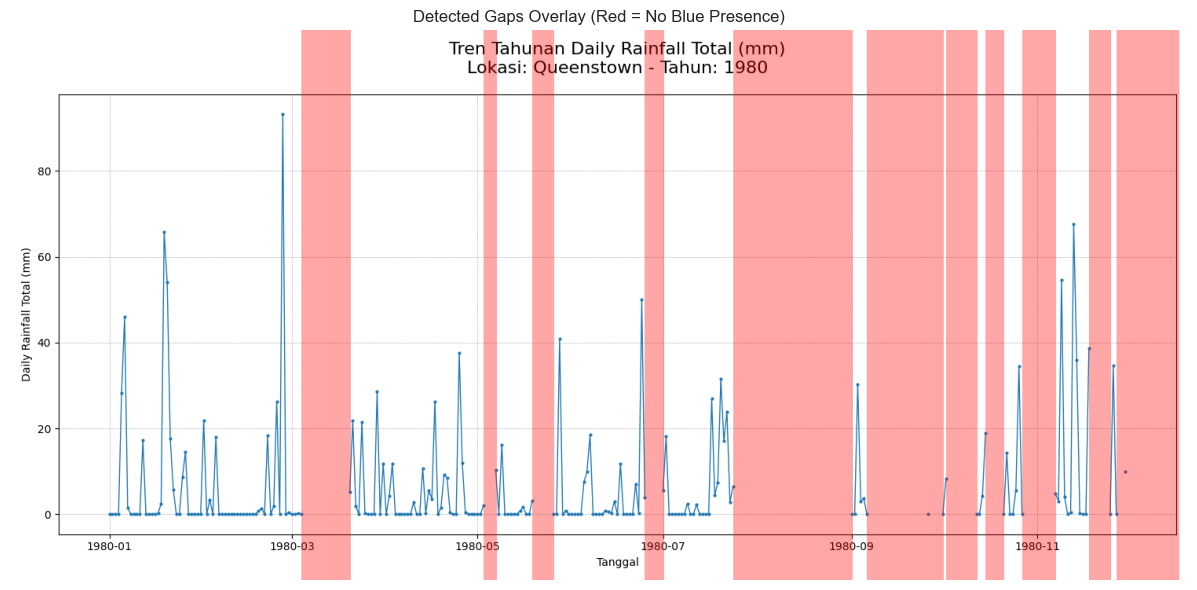

In [224]:
def detect_missing_ranges(
    dots,
    boundaries,
    xticks,
    candidates,
):
    xs = sorted(x for x, _ in dots)

    x0 = boundaries["data_start"]
    x1 = boundaries["data_end"]

    min_dx = min(candidates)
    max_dx = max(candidates)

    missing_ranges = []

    first_dot_x = xs[0]

    if first_dot_x > x0:
        missing_ranges.append(
            (x0 - min_dx, first_dot_x)
        )

    for i in range(len(xs) - 1):
        dx = xs[i + 1] - xs[i]

        if dx > max_dx + 1:
            missing_ranges.append(
                (xs[i], xs[i + 1])
            )

    last_dot_x = xs[-1]
    last_xtick_x, last_xtick_ts, _ = xticks[-1]

    if x1 > last_dot_x:
        if not is_year_start(last_xtick_ts):
            missing_ranges.append(
                (last_dot_x, x1 + min_dx)
            )
        else:
            if x1 - last_dot_x >= max_dx + 1:
                missing_ranges.append(
                    (last_dot_x, x1)
                )
            else:
                pass

    return missing_ranges

missing_ranges = detect_missing_ranges(
    dots=dots,
    boundaries=boundaries,
    xticks=xticks_full,
    candidates=candidates
)
visualize_gaps_on_image(demo_image, missing_ranges)

In [225]:
missing_ranges

[(371, 433),
 (603, 619),
 (665, 692),
 (808, 832),
 (921, 1072),
 (1091, 1169),
 (1169, 1188),
 (1192, 1231),
 (1242, 1265),
 (1289, 1331),
 (1374, 1401),
 (1409, 1420),
 (1420, 1488)]

In [226]:
from collections import Counter
import math
import numpy as np

INF = 1e18

def valid_extras_for_dx(dx, remaining, candidates):
    c1, c2 = candidates
    d = c2 - c1
    valid = set()

    for extra in range(0, remaining + 1):
        n_intervals = extra + 2

        if d == 0:
            if dx == n_intervals * c1:
                valid.add(extra)
            continue

        num = dx - n_intervals * c1
        if num < 0 or num % d != 0:
            continue

        b = num // d
        if 0 <= b <= n_intervals:
            valid.add(extra)

    return valid


def _solve_ab_for_dx(dx, n_intervals, candidates):
    c1, c2 = candidates
    d = c2 - c1
    if d == 0:
        if dx == n_intervals * c1:
            return (n_intervals, 0)
        return None

    num = dx - n_intervals * c1
    if num < 0 or num % d != 0:
        return None

    b = num // d
    if not (0 <= b <= n_intervals):
        return None

    a = n_intervals - b
    return (a, b)


def _ratio_cost(a, b, r_target):
    if b == 0:
        return abs((1e9) - r_target)

    r = a / b
    return abs(r - r_target)


def assign_missing_with_constraint_ratio(
    pairs,
    n_missing_total,
    candidates,
    dx_hist=None,
    target_ratio=None,
    verbose=False,
):
    G = len(pairs)
    if n_missing_total < G:
        raise RuntimeError("Total missing < number of gaps")
    remaining = n_missing_total - G

    c1, c2 = sorted(candidates)
    candidates = (c1, c2)

    if target_ratio is None:
        if dx_hist is None:
            r_target = 1.0
        else:
            count_c1 = dx_hist.get(c1, 0)
            count_c2 = dx_hist.get(c2, 0)
            if count_c2 == 0:
                r_target = 1e9
            else:
                r_target = count_c1 / count_c2
    else:
        r_target = float(target_ratio)

    if verbose:
        print(f"[RATIO] target a/b ~ {r_target:.6f} (a=min_dx intervals, b=max_dx intervals)")

    gap_opts = []
    for (x_left, x_right) in pairs:
        dx = abs(x_right - x_left)
        feas = valid_extras_for_dx(dx, remaining, candidates)
        if not feas:
            raise RuntimeError(f"No feasible extra for dx={dx}")

        opts = []
        for extra in sorted(feas):
            n_intervals = extra + 2
            ab = _solve_ab_for_dx(dx, n_intervals, candidates)
            if ab is None:
                continue
            a, b = ab
            cost = _ratio_cost(a, b, r_target)
            opts.append((extra, cost, a, b))

        if not opts:
            raise RuntimeError(f"Feasible extras exist but no (a,b) solutions for dx={dx}")

        gap_opts.append(opts)

    dp = [(INF, None, None, None, None)] * (remaining + 1)
    dp[0] = (0.0, None, None, None, None)

    parents = []
    for gi, opts in enumerate(gap_opts):
        new_dp = [(INF, None, None, None, None)] * (remaining + 1)
        for s in range(remaining + 1):
            base_cost, *_ = dp[s]
            if base_cost >= INF:
                continue
            for extra, cost, a, b in opts:
                ns = s + extra
                if ns > remaining:
                    continue
                cand_cost = base_cost + cost
                if cand_cost < new_dp[ns][0]:
                    new_dp[ns] = (cand_cost, s, extra, a, b)
        dp = new_dp
        parents.append(dp)

    final_cost, prev_s, extra, a, b = dp[remaining]
    if final_cost >= INF:
        raise RuntimeError("No DP solution meets global extra constraint")

    chosen = [None] * G
    s = remaining
    for gi in range(G - 1, -1, -1):
        cost, ps, ex, aa, bb = parents[gi][s]
        if ps is None and gi != 0:
            raise RuntimeError("DP reconstruction failed")
        chosen[gi] = (ex, aa, bb)
        s = ps if ps is not None else 0

    result = []
    final_missing = []
    for (x_left, x_right), (extra, a, b) in zip(pairs, chosen):
        n_missing = 1 + extra
        final_missing.append(n_missing)

        n_intervals = n_missing + 1
        if a + b != n_intervals:
            raise RuntimeError(f"(a+b) mismatch for gap {x_left}-{x_right}")

        result.append((n_missing, (a, b)))

    if verbose:
        print("[RESULT] Missing per gap:")
        for i, m in enumerate(final_missing):
            print(f"  gap {i:02d}: missing={m}, (a,b)={result[i][1]}")
        print(f"[CHECK] Σ missing = {sum(final_missing)} (expected {n_missing_total})")
        print(f"[COST] total ratio deviation cost = {final_cost:.6f}")

    return result

missing = assign_missing_with_constraint_ratio(
    pairs=missing_ranges,
    n_missing_total=n_missing,
    candidates=candidates,
    dx_hist=dict(top_dx),
    verbose=True,
)

[RATIO] target a/b ~ 0.149425 (a=min_dx intervals, b=max_dx intervals)
[RESULT] Missing per gap:
  gap 00: missing=15, (a,b)=(2, 14)
  gap 01: missing=3, (a,b)=(0, 4)
  gap 02: missing=6, (a,b)=(1, 6)
  gap 03: missing=5, (a,b)=(0, 6)
  gap 04: missing=38, (a,b)=(5, 34)
  gap 05: missing=19, (a,b)=(2, 18)
  gap 06: missing=4, (a,b)=(1, 4)
  gap 07: missing=9, (a,b)=(1, 9)
  gap 08: missing=5, (a,b)=(1, 5)
  gap 09: missing=10, (a,b)=(2, 9)
  gap 10: missing=6, (a,b)=(1, 6)
  gap 11: missing=2, (a,b)=(1, 2)
  gap 12: missing=17, (a,b)=(4, 14)
[CHECK] Σ missing = 139 (expected 139)
[COST] total ratio deviation cost = 1.129706


In [227]:
def insert_missing_dots_from_result(
    dots,
    missing_ranges,
    result,
    candidates,
    boundaries,
):
    dots_sorted = sorted(dots, key=lambda d: d[0])
    final_dots = []

    min_dx, max_dx = candidates
    data_start = boundaries["data_start"]

    dot_idx = 0

    for i, ((x_left, x_right), (n_missing, (cnt_min, cnt_max))) in enumerate(
        zip(missing_ranges, result)
    ):
        while dot_idx < len(dots_sorted) and dots_sorted[dot_idx][0] <= x_left:
            final_dots.append(dots_sorted[dot_idx])
            dot_idx += 1

        is_leading = (i == 0 and dot_idx == 0)
        if is_leading:
            cur_x = data_start
            final_dots.append((cur_x, np.nan))
            placed = 1
            n_missing = n_missing - 1
        else:
            cur_x = x_left
            placed = 0

        segments = [min_dx] * cnt_min + [max_dx] * cnt_max
        for d in segments[placed:placed + n_missing]:
            cur_x += d
            final_dots.append((cur_x, np.nan))

    while dot_idx < len(dots_sorted):
        final_dots.append(dots_sorted[dot_idx])
        dot_idx += 1

    return sorted(final_dots, key = lambda x:x[0])


all_dots = insert_missing_dots_from_result(
    dots=dots,
    missing_ranges=missing_ranges,
    result=missing,
    candidates=candidates,
    boundaries=boundaries
)
len_with_missing = len(all_dots)

print("Expected Dots:", expected_plot_n)
print("Final dots   :", len_with_missing)

Expected Dots: 352
Final dots   : 352


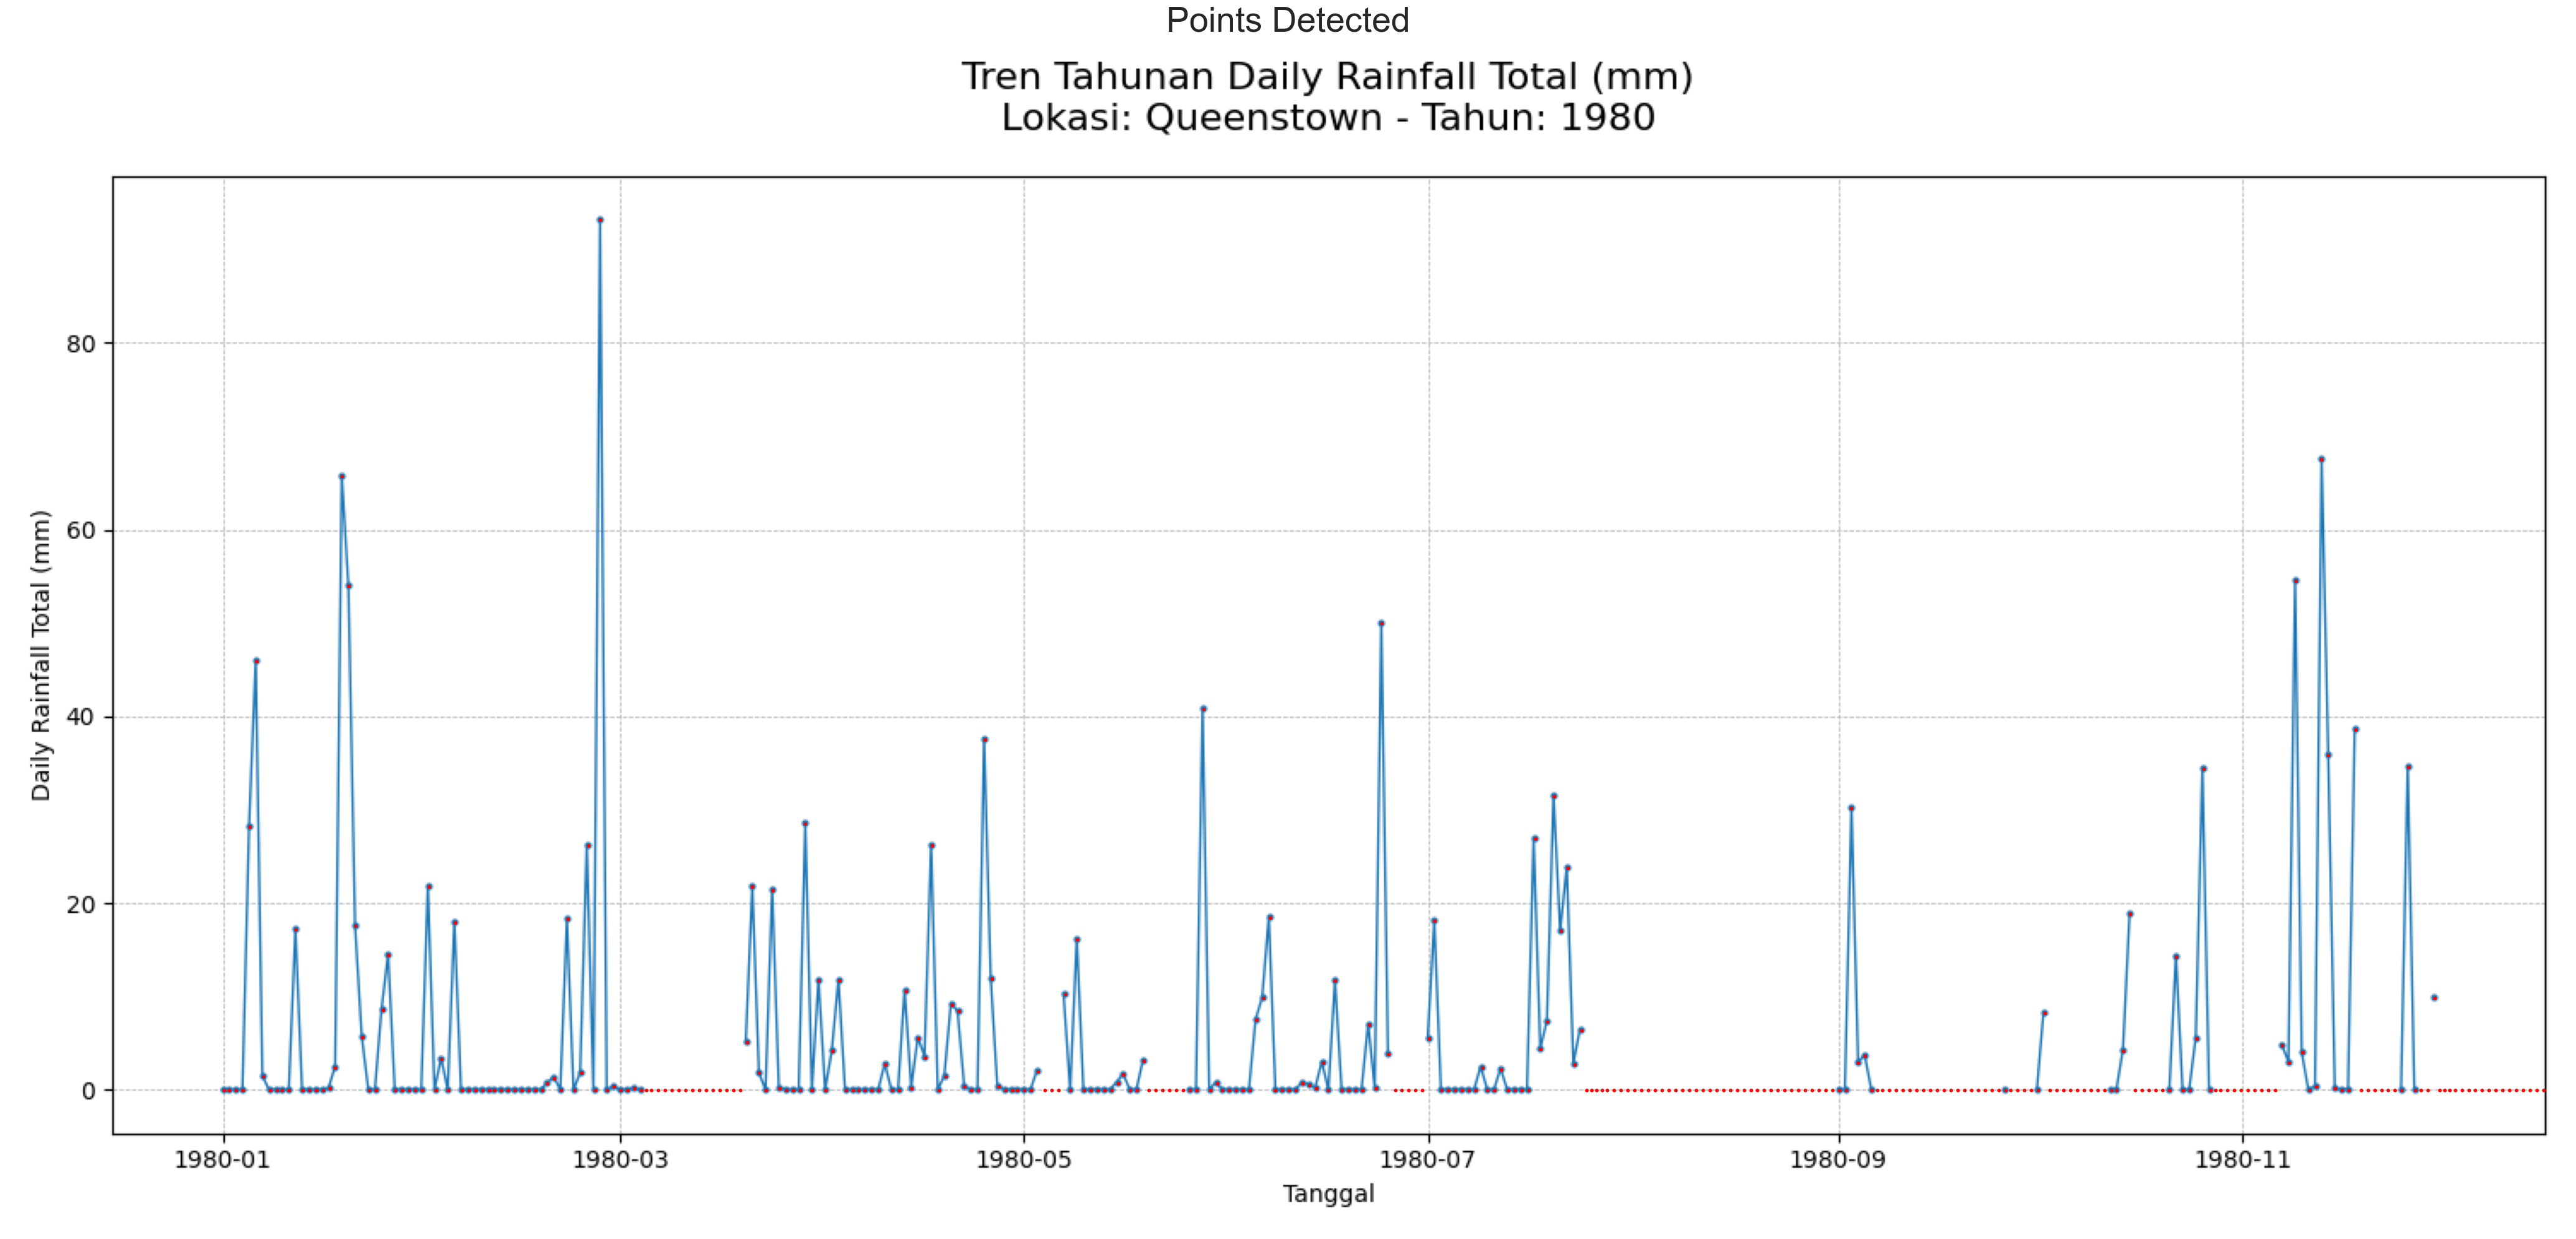

In [228]:
all_dots_ = [(x, 616) if np.isnan(y) else (x, y) for (x,y) in all_dots]
overlay_red_points(demo_image, all_dots_)

## **Mapper to Rainfall Velue**

In [229]:
def map_by_single_anchor(
    dots,
    anchor_dot,
    anchor_date,
    df,
):
    df["Date"] = pd.to_datetime(df["Date"])

    series = pd.Series(
        np.nan,
        index=df["Date"],
        name="y_px"
    )

    dot_idx = dots.index(anchor_dot)
    date_idx = df.index[df["Date"] == anchor_date][0]

    series.iloc[date_idx] = anchor_dot[1]

    di, dj = dot_idx + 1, date_idx + 1
    while di < len(dots) and dj < len(series):
        series.iloc[dj] = dots[di][1]
        di += 1
        dj += 1

    di, dj = dot_idx - 1, date_idx - 1
    while di >= 0 and dj >= 0:
        series.iloc[dj] = dots[di][1]
        di -= 1
        dj -= 1

    return series

mapped_x = map_by_single_anchor(
    df=demo_df,
    anchor_dot=anchor_dot,
    anchor_date=anchor_date,
    dots=all_dots
)
mapped_x.head()

Date
1980-01-01    616.0
1980-01-02    616.0
1980-01-03    616.0
1980-01-04    616.0
1980-01-05    462.0
Name: y_px, dtype: float64

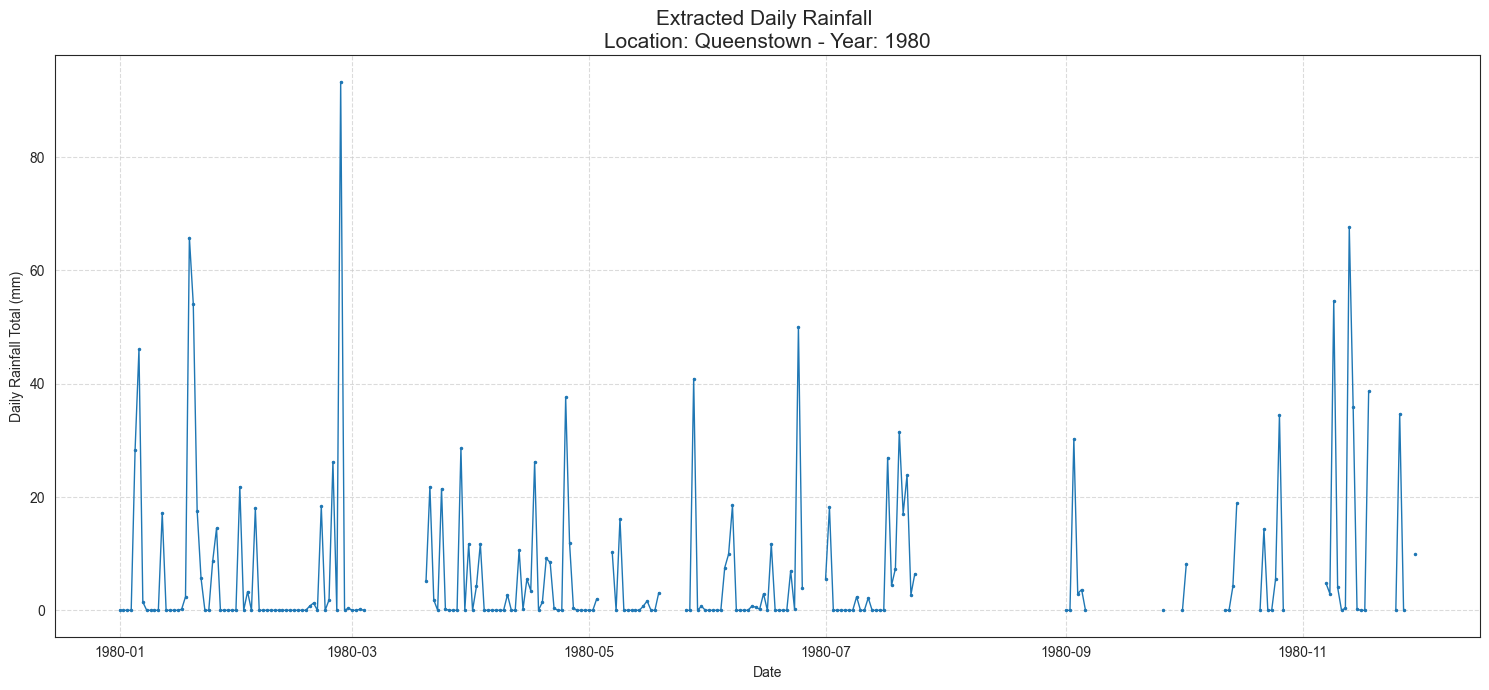

In [230]:
def y_px_to_rainfall(series_px, y_to_value):
    series_mm = series_px.copy()

    for idx, y in series_mm.items():
        if pd.isna(y):
            series_mm.loc[idx] = np.nan
        else:
            series_mm.loc[idx] = float(y_to_value(y))

    series_mm.name = "daily_rainfall_total_mm"
    return series_mm

y_to_value  = mapper.build_y_pixel_to_value(snapped_labels)
rainfall = mapper.y_px_to_rainfall(series_px=mapped_x, y_to_value=y_to_value)

recreate_plot(rainfall, location, year)

# **Full Pipeline**

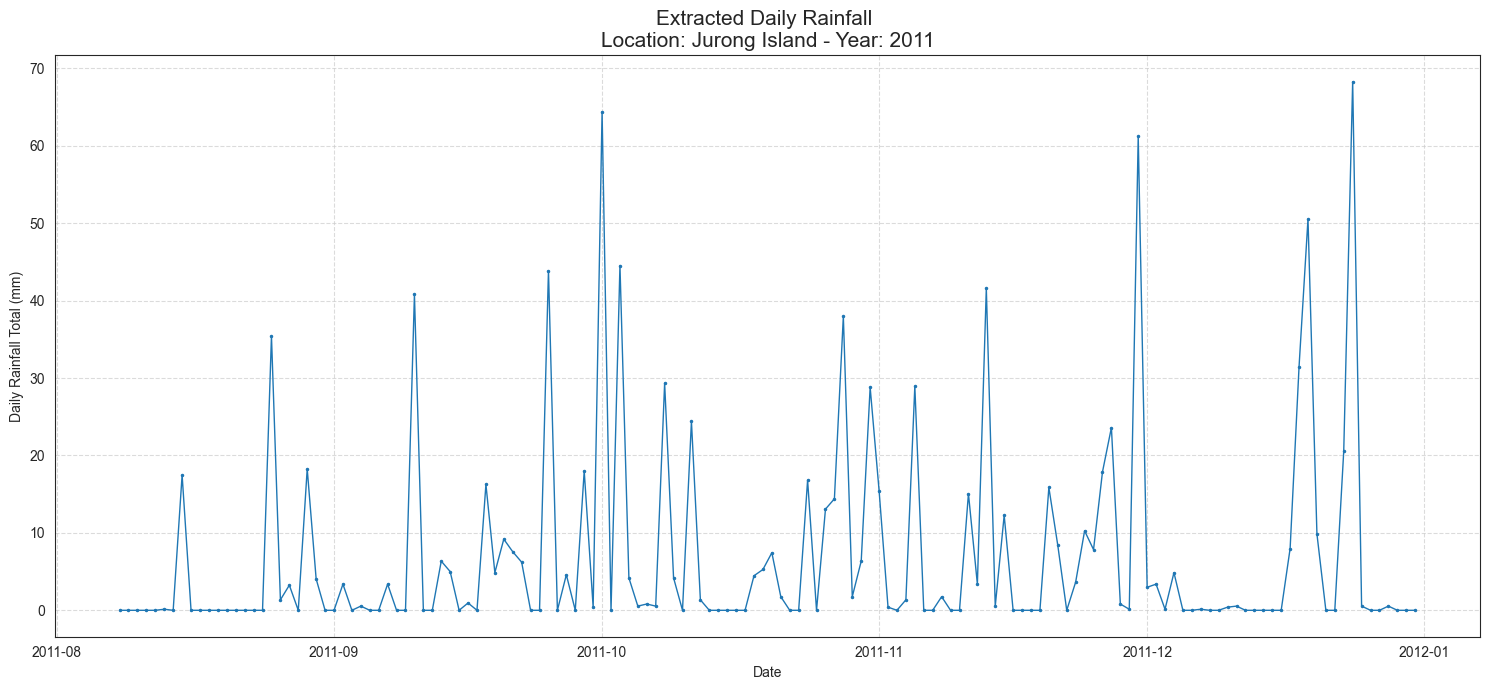

In [ ]:
def extract_rainfall_from_plot(
    png: str | Path,
    csv: str | Path,
    dot_color: tuple[int] = (31, 119, 180),
    color_tolerance: int = 4,
    label_px_tolerance: int = 5,
    label_ocr_pad: int = 5,
    ticks_px_tolerance: int = 2,
    vertical_right: int = 80,
    show: bool = False,
    verbose: bool = False,
):
    image = cv2.imread(png)
    blue = utils.extract_blue_mask(image)

    df = pd.read_csv(csv)
    df["Date"] = pd.to_datetime(df["Date"])

    df = (
        df
        .set_index("Date")
        .reindex(
            pd.date_range(start=df["Date"].min(),
                          end=df["Date"].max(),
                          freq="D")
        )
        .rename_axis("Date")
        .reset_index()
    )
    n_days = len(df)
    vertical_grid, horizontal_grid = metadata.detect_grid(image,
                                                          right_px=vertical_right,
                                                          show=show)

    mask, (x0, x1) = detector.detect_dot_mask(
        image_bgr=image,
        target_rgb=dot_color,
        tolerance=color_tolerance,
    )

    dots = detector.extract_dots(mask)

    label_ocr = metadata.perform_ocr(image,
                                     punctuation=False,
                                     roi_x0=27,
                                     roi_x1=vertical_grid[0]+label_ocr_pad,
                                     show=show)

    labels = metadata.extract_yticks_from_ocr(label_ocr)
    items = labels.items()

    snapped_items = utils.snap_values(
        items,
        horizontal_grid,
        get_value=lambda item: item[1][1],
        set_value=lambda item, y: (item[0], (item[1][0], y)),
        tol_px=label_px_tolerance,
    )

    snapped_labels = dict(snapped_items)

    date_ocr = metadata.perform_ocr(image,
                                    punctuation=True,
                                    roi_y0=horizontal_grid[-1],
                                    show=show)

    xticks = metadata.extract_xticks_from_ocr(date_ocr)
    snapped_xticks = utils.snap_values(
        xticks,
        vertical_grid,
        get_value=lambda item: item[0],
        set_value=lambda item, x: (x, item[1], item[2]),
        tol_px=ticks_px_tolerance,
    )

    top_dx = metadata.most_common_x_distances(
        dots,
        verbose=verbose
    )
    candidates = sorted([delta for delta, _ in top_dx])

    boundaries = metadata.find_data_boundaries(
        blue_mask=blue,
        vertical_grid=vertical_grid,
        xticks=snapped_xticks,
        delta=max(candidates)
    )
    x0 = boundaries["data_start"]
    x1 = boundaries["data_end"]

    xticks_full = utils.extend_xticks(snapped_xticks, boundaries)

    t0, t1 = utils.estimate_plot_time_window_from_xticks(
        xticks=xticks_full,
        data_start_px=boundaries["data_start"],
        data_end_px=boundaries["data_end"],
    )

    expected_plot_n = utils.expected_n_in_plot(df["Date"], t0, t1)
    extracted_dot_n = len(dots)
    n_missing = expected_plot_n - extracted_dot_n

    max_dx = max(1, np.floor(365/n_days))
    matches = detector.find_dots_near_xticks(
        xticks=snapped_xticks,
        dots=dots,
        max_dx=max_dx,
        candidates=candidates
    )

    anchor_dot, anchor_date = detector.pick_best_anchor_from_matches(matches)
    missing_ranges = detector.detect_missing_ranges(
        dots=dots,
        boundaries=boundaries,
        xticks=xticks_full,
        candidates=candidates
    )

    missing = solver.assign_missing_with_constraint_ratio(
        pairs=missing_ranges,
        n_missing_total=n_missing,
        candidates=candidates,
        dx_hist=dict(top_dx),
        verbose=verbose,
    )

    all_dots = solver.insert_missing_dots_from_result(
        dots=dots,
        missing_ranges=missing_ranges,
        result=missing,
        candidates=candidates,
        boundaries=boundaries
    )
    len_with_missing = len(all_dots)

    mapped_x = mapper.map_by_single_anchor(
        dots=all_dots,
        anchor_dot=anchor_dot,
        anchor_date=anchor_date,
        df=df,
    )

    y_to_value  = mapper.build_y_pixel_to_value(snapped_labels)
    rainfall = mapper.y_px_to_rainfall(series_px=mapped_x, y_to_value=y_to_value)

    return rainfall

r()
location = "Jurong Island"
year = 2011

png, csv = generate_demo(location, year)
rainfall = extract_rainfall_from_plot(png, csv)

recreate_plot(rainfall, location, year)

In [346]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

daily = pd.read_csv(
    config.paths.clean/'daily_v2.csv'
).dropna(subset=["extracted_mm", "observed_mm"])

mae = mean_absolute_error(daily.extracted_mm, daily.observed_mm)
rmse = root_mean_squared_error(daily.extracted_mm, daily.observed_mm)

print("MAE Global  :", mae)
print("RMSE Global :", rmse)

MAE Global  : 0.04419694425775394
RMSE Global : 0.10633021030825947


In [ ]:
daily["date"] = pd.to_datetime(daily["date"])
daily["year"] = daily["date"].dt.year

def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

rmse_by_year_location = (
    daily
    .groupby(["year", "location"])
    .apply(lambda df: rmse(df["extracted_mm"], df["observed_mm"]))
    .reset_index(name="rmse")
)

best_groups = rmse_by_year_location[
    rmse_by_year_location["rmse"] == min(rmse_by_year_location["rmse"])
].sort_values("rmse", ascending=False)

print(best_groups)

     year    location     rmse
889  2018  Ang Mo Kio  0.00256


MAE:  0.00017504511595580738
RMSE:  0.0025604660466870526


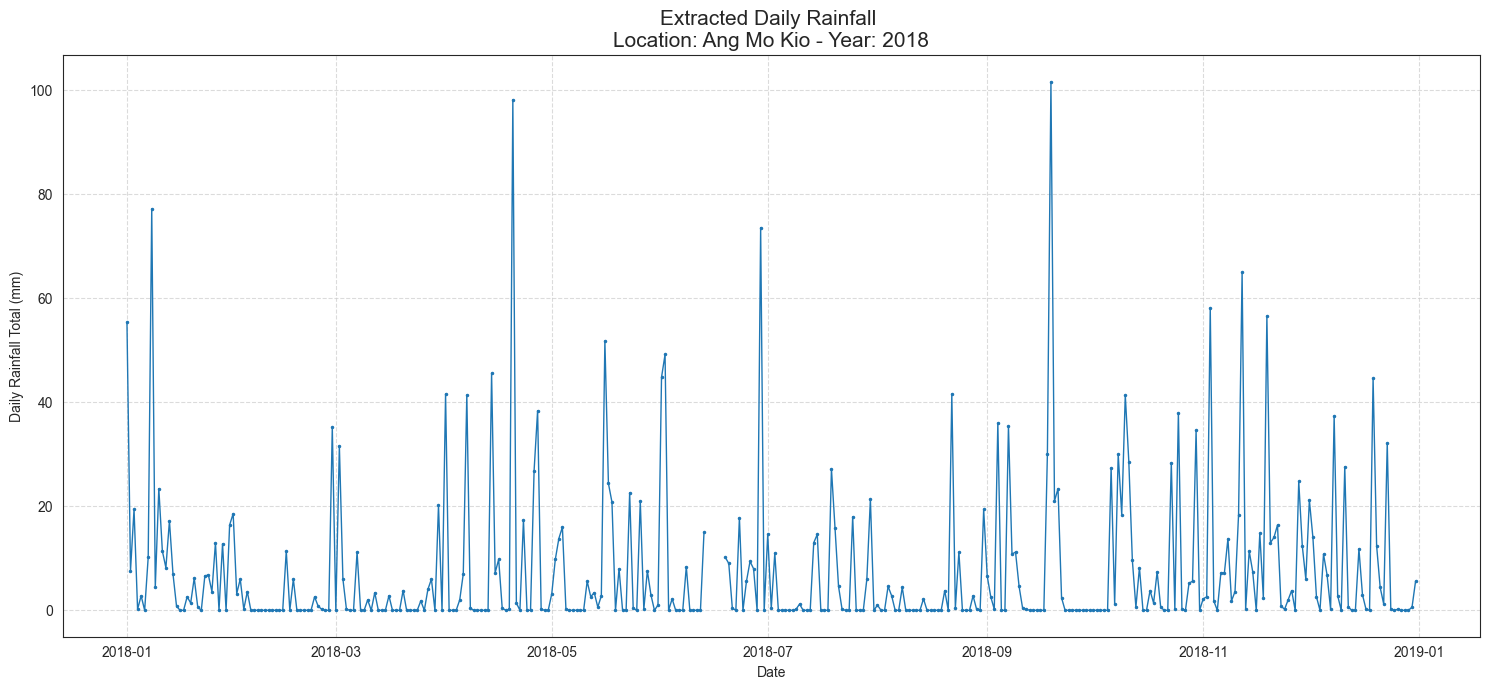

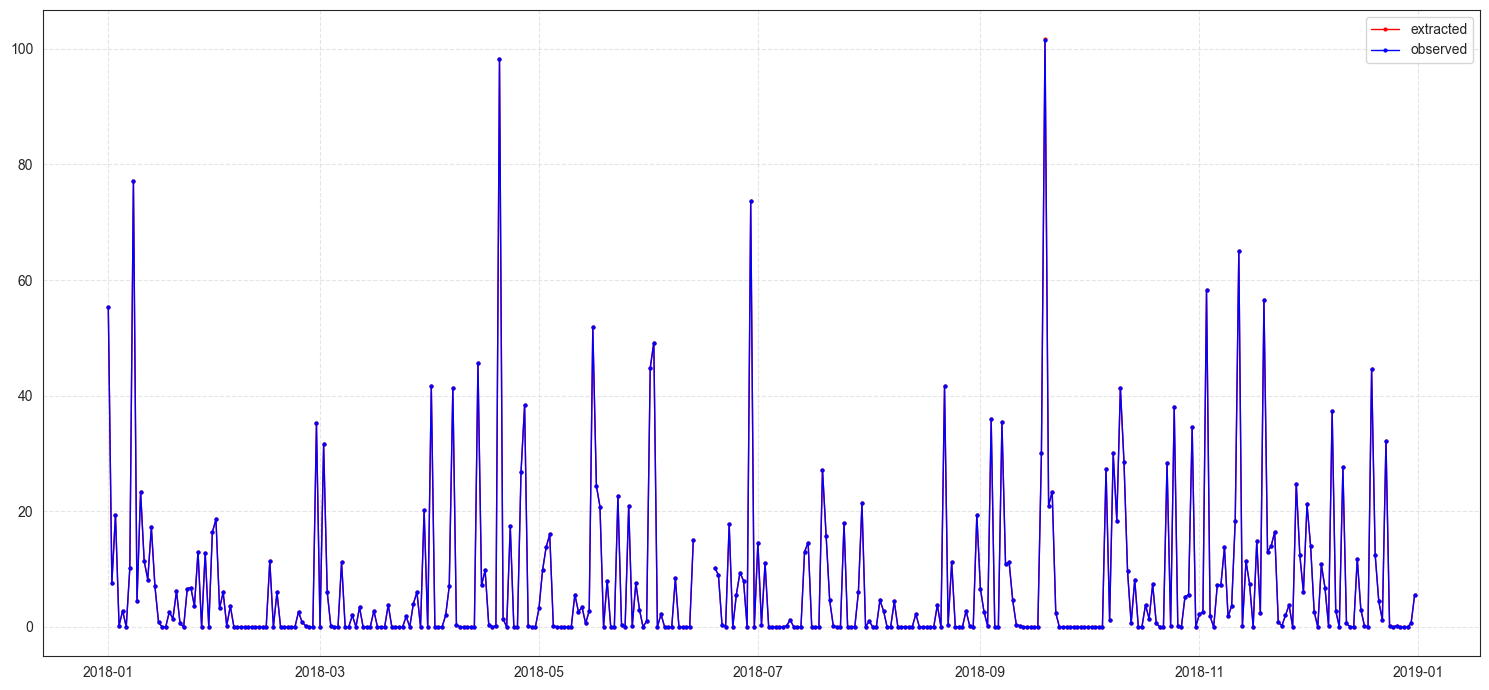

In [347]:
import src.dots_extractor_v2.pipeline as dots_v2

r([dots_v2])
def compare(png, csv, location, year, verbose=False, plot=False):
    rainfall = extract_rainfall_from_plot(png, csv)

    extracted_df = (
        rainfall
        .rename("extracted_mm")
        .reset_index()
        .rename(columns={"index": "Date"})
    )

    extracted_df["date"] = pd.to_datetime(extracted_df["Date"])
    extracted_df["location"] = location

    daily["date"] = pd.to_datetime(daily["date"])

    daily_loc = daily[daily["location"] == location][
        ["date", "location", "observed_mm"]
    ]

    plot_df = extracted_df.merge(
        daily_loc,
        on=["date", "location"],
        how="left"
    ).sort_values("date").set_index("date")

    metrics_df = plot_df.dropna(
        subset=["observed_mm", "extracted_mm"]
    )

    mae = mean_absolute_error(
        metrics_df["observed_mm"],
        metrics_df["extracted_mm"]
    )
    rmse = root_mean_squared_error(
        metrics_df["observed_mm"],
        metrics_df["extracted_mm"]
    )

    print("MAE: ", mae)
    print("RMSE: ", rmse)

    if plot:
        recreate_plot(rainfall, location, year)
        plt.figure(figsize=(15, 7))
        plt.grid(True, alpha=0.5, linestyle="--")

        plt.plot(plot_df["extracted_mm"], color="red", marker = "o", markersize=2, linewidth=1)
        plt.plot(plot_df["observed_mm"], color = "blue", marker = "o", markersize=2, linewidth=1)
        plt.legend(["extracted", "observed"])

        plt.tight_layout()
        plt.show()

location, year = "Ang Mo Kio", 2018
png, csv = generate_demo(location, year)

compare(png, csv, location, year, plot=True, verbose=True)

# **City Check**

In [9]:
# location = "Admiralty"
# for year in range(2009, 2024):
#     print(f"Year: {year}")
#     png, csv = generate_demo(location, year)

#     compare(png, csv, location, year, plot=True, verbose=False)